In [1]:
# https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

# Introduction

This tutorial focuses on predicting financial data. We have historical Bitcoin data with daily predictors and daily timesteps: 
- Opening price 
- High price 
- Low price 
- Volume traded

The objective is to take in a sequence of the above 4 values (i.e. from 100 previous days) to predict the target variable (Bitcoin's price) for the next 50 days in the future.

# Data Preprocessing

<del>Because financial data is readily available, we can use that from Yahoo historical prices for Bitcoin - available from 9/17/2014 until 1/14/2022.

<del> **Note:** YFinance has placed this data currently behind a paywall. Instead I will import the data from YFinance. 

Now, that we have completed the tutorial let's apply this to our data.

In [ ]:
# import yfinance as yf

In [3]:
# data = yf.download("BTC-USD", start="2014-09-17", end="2022-01-15")
# data.to_csv("BTC-USD.csv")

In [4]:
prediction_window = 10
forward_window = 20

In [5]:
filename = "5_resampled_1min_interval.csv"

In [6]:
import pandas as pd 

# data = pd.read_csv("BTC-USD.csv", skiprows=[1,2])
# data

df = pd.read_csv(filename)

df = df[["SV Name", "epoch", "Clock Bias (seconds)", "File"]]
df.T

,0,1,2,3,4,5,6,7,8,9,...,308181,308182,308183,308184,308185,308186,308187,308188,308189,308190
SV Name,1,1,1,1,1,1,1,1,1,1,...,32,32,32,32,32,32,32,32,32,32
epoch,2018-04-15 00:00:00,2018-04-15 00:01:00,2018-04-15 00:02:00,2018-04-15 00:03:00,2018-04-15 00:04:00,2018-04-15 00:05:00,2018-04-15 00:06:00,2018-04-15 00:07:00,2018-04-15 00:08:00,2018-04-15 00:09:00,...,2018-04-21 21:51:00,2018-04-21 21:52:00,2018-04-21 21:53:00,2018-04-21 21:54:00,2018-04-21 21:55:00,2018-04-21 21:56:00,2018-04-21 21:57:00,2018-04-21 21:58:00,2018-04-21 21:59:00,2018-04-21 22:00:00
Clock Bias (seconds),-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,...,-0.000518,-0.000518,-0.000518,-0.000518,-0.000518,-0.000518,-0.000518,-0.000518,-0.000518,-0.000518
File,KITG00UZB_R_20181040000_01D_GN.rnx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRUX00BEL_R_20181120000_01D_GN.rnx


In [7]:
# data.rename(columns={"Price": "Date"}, inplace=True)
# data

In [8]:
# data.to_csv("BTC-USD.csv", index=False)

In [9]:
# pd.read_csv("BTC-USD.csv")

In [10]:
df.describe()

,SV Name,Clock Bias (seconds)
count,308191.000000,308191.000000
mean,16.904595,-0.000005
std,9.100347,0.000343
min,1.000000,-0.000737
25%,9.000000,-0.000218
50%,17.000000,-0.000010
75%,25.000000,0.000205
max,32.000000,0.000708


# Continuing article's work

In [11]:
# df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
# df.head(5)

df = pd.read_csv(filename, index_col = 'epoch', parse_dates=True)
df = df[["SV Name", "Clock Bias (seconds)", "File"]]
df = df[df["SV Name"] == 1]
df.head(5)

,SV Name,Clock Bias (seconds),File
epoch,,,
2018-04-15 00:00:00,1,-0.000041,KITG00UZB_R_20181040000_01D_GN.rnx
2018-04-15 00:01:00,1,-0.000041,NaN
2018-04-15 00:02:00,1,-0.000041,NaN
2018-04-15 00:03:00,1,-0.000041,NaN
2018-04-15 00:04:00,1,-0.000041,NaN


In [12]:
# df = df.drop(columns=["File", "SV Name.1"])

In [13]:
df[(df["SV Name"] == 1)]["Clock Bias (seconds)"]

epoch
2018-04-15 00:00:00   -0.000041
2018-04-15 00:01:00   -0.000041
2018-04-15 00:02:00   -0.000041
2018-04-15 00:03:00   -0.000041
2018-04-15 00:04:00   -0.000041
                         ...   
2018-04-21 21:56:00   -0.000042
2018-04-21 21:57:00   -0.000042
2018-04-21 21:58:00   -0.000042
2018-04-21 21:59:00   -0.000042
2018-04-21 22:00:00   -0.000042
Name: Clock Bias (seconds), Length: 9961, dtype: float64

Visualize your data by plotting the target variable of interest. It is recommended to regress the target variable on the predictors to look for linear relationships between variables. 

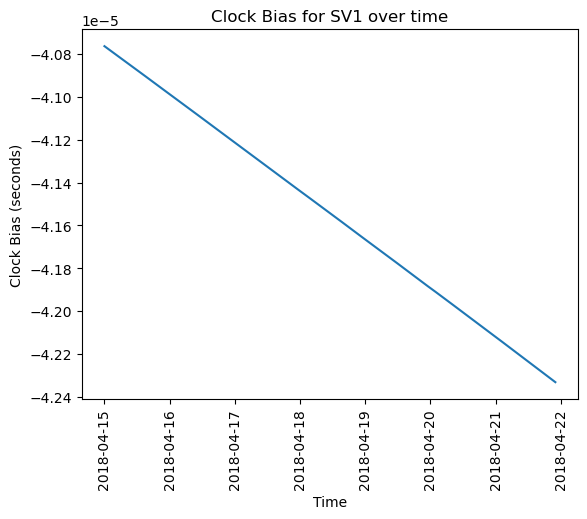

In [14]:
# import matplotlib.pyplot as plt

# plt.plot(df.Close)
# plt.xlabel("Time")
# plt.ylabel("Price (USD)")
# plt.title("Bitcoin price over time")
# plt.savefig("initial_plot.png", dpi = 250)
# plt.show(); 

import matplotlib.pyplot as plt

plt.plot(df[(df["SV Name"] == 1)]["Clock Bias (seconds)"])
plt.xlabel("Time")
plt.ylabel("Clock Bias (seconds)")
plt.xticks(rotation=90)
plt.title("Clock Bias for SV1 over time")
plt.savefig("sv1_clock_bias_plot.png", dpi = 250)
plt.show(); 

# Seeing inputs and outputs

Our predictors consist of all the columns except the target, in this case the closing price. We can use the <code>sklearn</code> processor to reshape the array if it consists of a single feature, as our target does. Therefore, for target, <code>y</code>, we call <code>values</code>. This removes the axis labels to enable us to reshape the array. 

In [15]:
X, y = df.drop(columns=['File']), df['Clock Bias (seconds)'] # in this case, it would be useful to have col names without spaces 
X.shape, y.shape

((9961, 2), (9961,))

Now, we can standardize the features. We'll use standardization for our training features, <code>x</code> by removing the mean and scaling to unit variance. 

Standardization enables the model to learn by ensuring that parameters can exist in the same multi-dimensional space. It wouldn't make much sense to have the weights have to change their size simply because the variables are on different scales. For our target <code>y</code>, we will scale and translate each feature individually between 0 and 1. This transformation is often used as an alternative to zero mean, unit variance, scaling. 

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
# y_trans = mm.fit_transform(y.reshape(-1,1)) # reshape has been deprecated https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape 
y_trans = mm.fit_transform(y.values.reshape(-1,1))

This is the "fiddly" part. We want to feed 100 samples, up to the current day, and predict the next 50 time step values. To do this, we need a special function to ensure that the corresponding indices of <code>X</code> and y represent this structure. Examine this function carefully but it just boils down to getting 100 samples from <code>X</code>, then looking at the next 50 indices in y and pathing these together. Note that because of this we'll throw out the first 50 values of <code>y</code>.

In [17]:
import numpy as np 

def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break

        # gather input and output of the pattern 
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, prediction_window, forward_window)
print(X_ss.shape, y_mm.shape)


(9933, 10, 2) (9933, 20)


Let's check if the first sample in <code>y_mm</code> starts at the 100th sample in the original <code>y</code> vector

In [18]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

In [19]:
y_mm[0]

array([0.99911287, 0.9990143 , 0.99891573, 0.99881716, 0.99871859,
       0.99862001, 0.99852144, 0.99842287, 0.9983243 , 0.99822573,
       0.99812716, 0.99802859, 0.99793002, 0.99783145, 0.99773288,
       0.99763431, 0.99753574, 0.99743717, 0.9973386 , 0.99724003])

In [20]:
y_trans[99:149].squeeze(1)

array([0.99024153, 0.99014296, 0.99004439, 0.98994582, 0.98984725,
       0.98974868, 0.98965011, 0.98955154, 0.98945297, 0.9893544 ,
       0.98925583, 0.98915726, 0.98905869, 0.98896012, 0.98886155,
       0.98876298, 0.98866441, 0.98856584, 0.98846727, 0.9883687 ,
       0.98827012, 0.98817155, 0.98807185, 0.98797215, 0.98787245,
       0.98777276, 0.98767306, 0.98757336, 0.98747366, 0.98737396,
       0.98727426, 0.98717456, 0.98707486, 0.98697516, 0.98687546,
       0.98677576, 0.98667606, 0.98657636, 0.98647666, 0.98637696,
       0.98627726, 0.98617756, 0.98607786, 0.98597816, 0.98587846,
       0.98577876, 0.98567906, 0.98557936, 0.98547966, 0.98537996])

We want to predict the data several months into the future, therefore we can use a training data size of 95% with 5% left for the remaining data for prediction. This gives us a training set of 2763 day (or 7.5 years) and predicting 145 days into the future (5 months). 

In [21]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

In [22]:
X_train = X_ss[:-150]
X_test = X_ss[-150:]

In [23]:
y_train = y_mm[:-150]
y_test = y_mm[-150:]

In [24]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (9783, 10, 2) (9783, 20)
Testing Shape: (150, 10, 2) (150, 20)


Now we convert our data into tensors by calling <code>torch.tensor()</code> on our object, and setting the property <code>requires_grad = True</code>. Some old PyTorch tutorials might indicate that we need to apply <code>Variable</code> on here but this is deprecated. Now the input tensor to be forward propagated has to be can faciliate automatic back propagation through <code> backward()</code> without being wrapped.

In [25]:
import torch 

# convert to pytorch tensors 
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

Looking through the documentation for a multi-layer <code>torch.nn.LSTM</code> shows that the input shape depends on whether the parameter <code>batch_first</code> is true. Since we are accustomed to having the first dimension be the batch, we can set <code>batch_first</code> to true. The size of the input is then <code>(N, L, H_in)</code> where

- N is the batch size 
- L is the sequence length
- H_in is the input size (number of features)

In other words, we wantt eh dimensions to be the rows of the dataframe in the first dimension. Followed by the length of the dataframe in the next dimension to represent the length of the input sequence, and finally the feature of which we have 4 in the final dimension. 

To reshape the tensors into our required shape we can use <code>torch.reshape</code>. This takes as arguments the tensors we are reshaping, and then a tuple of the shape we need to reshape to. For the rows of the dataframe, we can simply look at the shape of the first dimension <code>X_train_tensors.shape[0]</code>. Since we are applying an LSTM, we call tha tthe sequence length we feed in is simply 1 because the whole point of the LSTM is not feeding in tons of data at each because the emory is handled by the inner working of the LSTM cell. 

The last dimension is the number of features which is stored in the <code>X_train_tensors.shape[1]</code>. 

In [26]:
# reshape to rows, timestamps, features 

X_train_tensors_final = torch.reshape(X_train_tensors, 
                                      (X_train_tensors.shape[0], prediction_window, 
                                      X_train_tensors.shape[2]))

X_test_tensors_final = torch.reshape(X_test_tensors, 
                                     (X_test_tensors.shape[0], prediction_window, 
                                      X_test_tensors.shape[2]))

print("Training shape:", X_train_tensors.shape, y_train_tensors.shape)
print("Testing shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training shape: torch.Size([9783, 10, 2]) torch.Size([9783, 20])
Testing shape: torch.Size([150, 10, 2]) torch.Size([150, 20])


Let's make sure that the data logic of the test set checks out. Sequential data is hard to get our heads around and especially when generating a test set for multistep output models. Here, we want to take the 100 previous predictors up to the current time step and predict 50 time steps into the future. In the test set, we have 150 batch feature samples, each consisting of 100 time steps and 4 feature predictors. 

In the targets for the test set, we again have 150 batch samples, each consisting of an array of length 50 of scalar outputs. 

Since we want a way to validate our results, we need to predict the Bitcoin price for 50 time steps in the test set for which we have the data (i.e. the test targets). Because of the way we wrote the <code> split_sequence()</code>, we just need the last sample of 100 days in <code>X_test</code>, run the model on it and compare those predictions with the last sample of the 50 days of <code>y_test</code>. These correspond to a period of 100 days in the <code>X_test</code>'s last sample, proceeded immediately by the next 50 days in the last sample of <code>y_test</code>. 

In [27]:
X_check, y_check = split_sequences(X, y.values.reshape(-1,1), prediction_window, forward_window) # see above - just doing y.reshape is deprecated
X_check[-1][0:4]

array([[ 1.00000000e+00, -4.23277528e-05],
       [ 1.00000000e+00, -4.23279114e-05],
       [ 1.00000000e+00, -4.23280700e-05],
       [ 1.00000000e+00, -4.23282286e-05]])

In [28]:
X.iloc[-149:-145]

,SV Name,Clock Bias (seconds)
epoch,,
2018-04-21 19:32:00,1,-0.000042
2018-04-21 19:33:00,1,-0.000042
2018-04-21 19:34:00,1,-0.000042
2018-04-21 19:35:00,1,-0.000042


The first four rows of the data match. Note that <code>X_check[-1]</code> should be identical to the <code>X.iloc[-149:-49]</code>, ending 50 days before the end of our dataset. Therefore, we are taking the 100 timesteps of information up to the 26th of Nov 2021, and attempting to predict the 50 days after that up to 14th January 2022. Our final check is to make sure that the final batch sample in our test targets matches these data predictions. 

In [29]:
y_check[-1]

array([-4.23291801e-05, -4.23293387e-05, -4.23294972e-05, -4.23296558e-05,
       -4.23298144e-05, -4.23299730e-05, -4.23301316e-05, -4.23302902e-05,
       -4.23304488e-05, -4.23306074e-05, -4.23307659e-05, -4.23309245e-05,
       -4.23310831e-05, -4.23312417e-05, -4.23314003e-05, -4.23315589e-05,
       -4.23317175e-05, -4.23318760e-05, -4.23320346e-05, -4.23321932e-05])

In [30]:
df["Clock Bias (seconds)"].values[-50:]

array([-4.23244225e-05, -4.23245811e-05, -4.23247397e-05, -4.23248982e-05,
       -4.23250568e-05, -4.23252154e-05, -4.23253740e-05, -4.23255326e-05,
       -4.23256912e-05, -4.23258498e-05, -4.23260083e-05, -4.23261669e-05,
       -4.23263255e-05, -4.23264841e-05, -4.23266427e-05, -4.23268013e-05,
       -4.23269599e-05, -4.23271185e-05, -4.23272770e-05, -4.23274356e-05,
       -4.23275942e-05, -4.23277528e-05, -4.23279114e-05, -4.23280700e-05,
       -4.23282286e-05, -4.23283871e-05, -4.23285457e-05, -4.23287043e-05,
       -4.23288629e-05, -4.23290215e-05, -4.23291801e-05, -4.23293387e-05,
       -4.23294972e-05, -4.23296558e-05, -4.23298144e-05, -4.23299730e-05,
       -4.23301316e-05, -4.23302902e-05, -4.23304488e-05, -4.23306074e-05,
       -4.23307659e-05, -4.23309245e-05, -4.23310831e-05, -4.23312417e-05,
       -4.23314003e-05, -4.23315589e-05, -4.23317175e-05, -4.23318760e-05,
       -4.23320346e-05, -4.23321932e-05])

Summary: The main performance test for our model will be on the last batch sample in the test set. This will be predictors rom the 100 time steps up to the 26th of Nov 2021 and this will be used by our model to predict the next 50 days of Bitcoin prices up to the 14th of Jan 2022. In this way, we validate model performance by comparing predcitions to the actual prices in that 50 day window. 

# Constructing the LSTM model

Now, let's construct the LSTM class, inheriting from the nn.Module. In constract to the previous univariate LSTM, we're going to build the model with the nn.LSTM rather than nn.LSTMCell because it's good to understand both options and we dont really need the nn.LSTMCell flexibility right now. We know that nn.LSTM is a recurrent application of the nn.LSTMCell. 

In [31]:
import torch.nn as nn

class LSTM(nn.Module): 
    def __init__(self, num_classes, input_size, hidden_size, num_layers): 
        super().__init__()
        self.num_classes = num_classes # output size 
        self.num_layers = num_layers # number of recurrent layers in the LSTM 
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm later

        # LSTM model 
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 128) # fully connected 
        self.fc2 = nn.Linear(128, num_classes) # last FC
        self.relu = nn.ReLU()

    def forward(self, x): 
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propgagate input through LSTM
        output, (hn, cn) =self.lstm(x, (h_0, c_0)) # (input, hidden and internal state)
        hn = hn.view(-1, self.hidden_size) # reshape data for Dense layer 
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In the initializations, we start with the parent class, nn.Module. Most initializations in PyTorch are separated into two chunks: 

- Any wariables that the class will need for reference, for things such as the hidden layer size, input size, and number of layers
- Defining the layers of the model without connecting them using the variables instatiated above 

Frist we need to shape the LSTM with input size, hidden size and number of recurrent layers. For instance num_layers=2 means stacking 2 LSTMs together to form a stacked LSTM with the second LSTM taking in outputs of the first LSTM and computing the final results. Thus we initialize these three variables in the first part of the __init__. We also need to force our model to output only 1 predicted value so we initialize the number of classes variable. 

In the second part of the __init__, we set out layers of our network with the first later obviously a recurrent aapplication of the LSTM cells, with the parameters specified above: 

<code> self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first= True)</code>

Next, we pass this to a fully connected layer which has an input of the hidden size (the size of the output from the last STM later), and outputs 128 activations. Then we pass these 128 activations to another hidden layer which accepts 128 inputs, and which we want our ouput num_classes (which in this clase would be 1). Finally we pass this activation through a non-linear function, the ReLU. 

<code>self.fc1 = nn.Linear(hidden_size, 128)</code>


<code>self.fc2 = nn.Linear(128, num_classes)</code>


<code>self.relu = nn.ReLU </code>

# Training

Here we will use a typical regression loss function like the MSE.

In [32]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(n_epochs): 
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient by manually setting to 0 

        # obtain loss function 
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function 
        optimiser.step() # improve the loss, i.e. backprop 

        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)

        if epoch % 2 == 0: 
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item()))

Here, we are doing the forward through the network by passing the training tensors, which we shaped before. We then zero out the current gradients in the torch computational graph. We compare these outputs from the forward pass with the actual train targets using our loss function, and backpropagate with loss.backward() to calculate the gradients of the loss wrt to the parameters (the weights and biases). We then use this loss to update the parameters. 

In [33]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 100
learning_rate = 0.001 

input_size = X_ss.shape[2] # num of features
hidden_size = 2 # num of features in the hidden state
num_layers = 1
num_classes = forward_window # num of output classes

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [34]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr = learning_rate)

In [35]:
training_loop(n_epochs=n_epochs, 
              lstm=lstm, 
              optimiser=optimiser, 
              loss_fn = loss_fn, 
              X_train=X_train_tensors_final, 
              y_train=y_train_tensors, 
              X_test=X_test_tensors_final, 
              y_test=y_test_tensors)


Epoch: 0, train loss: 0.33310, test loss: 0.01963
Epoch: 2, train loss: 0.29185, test loss: 0.02519
Epoch: 4, train loss: 0.25477, test loss: 0.03465
Epoch: 6, train loss: 0.22190, test loss: 0.04771
Epoch: 8, train loss: 0.19322, test loss: 0.06396
Epoch: 10, train loss: 0.16864, test loss: 0.08287
Epoch: 12, train loss: 0.14801, test loss: 0.10372
Epoch: 14, train loss: 0.13107, test loss: 0.12570
Epoch: 16, train loss: 0.11747, test loss: 0.14789
Epoch: 18, train loss: 0.10677, test loss: 0.16934
Epoch: 20, train loss: 0.09852, test loss: 0.18920
Epoch: 22, train loss: 0.09223, test loss: 0.20672
Epoch: 24, train loss: 0.08745, test loss: 0.22138
Epoch: 26, train loss: 0.08378, test loss: 0.23285
Epoch: 28, train loss: 0.08089, test loss: 0.24100
Epoch: 30, train loss: 0.07852, test loss: 0.24589
Epoch: 32, train loss: 0.07647, test loss: 0.24773
Epoch: 34, train loss: 0.07460, test loss: 0.24687
Epoch: 36, train loss: 0.07280, test loss: 0.24370
Epoch: 38, train loss: 0.07102, test

# Prediction

A key part of prediction, if the variables have been standardized, is known was we need to pass to the model. That is what do we need to standardize before passing it to hte model. We just apply the same transforms to the predictors and targets so that whatever we feed to the model is exactly what the model is seeing. It wouldnt make sense to not stardize our inpits; the model would be confused as to why they no longer have zero mean and unit variance. 

Let's plot the result for the full dataset

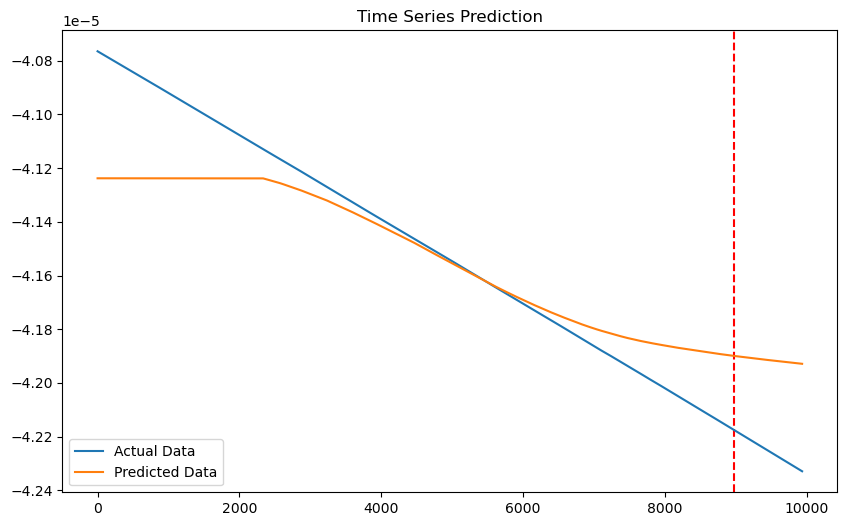

In [36]:
df_X_ss = ss.transform(df.drop(columns=['File'])) # old transformers 
df_y_mm = mm.transform(df["Clock Bias (seconds)"].values.reshape(-1,1)) # older transformers

#split sequences 
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, prediction_window, forward_window)

# convert tensors 
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

#reshape dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], prediction_window, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy()
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict)
dataY_plot = mm.inverse_transform(dataY_plot)

true, preds = [], []

for i in range(len(dataY_plot)): 
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)): 
    preds.append(data_predict[i][0])

plt.figure(figsize=(10,6))
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data')
plt.plot(preds, label='Predicted Data')
plt.title('Time Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi = 300)
plt.show()

In [37]:
from sklearn.metrics import r2_score

In [38]:
r2 = r2_score(true, preds)
r2

0.8010557016797581

In [39]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(true, preds)

0.0035868863375535655

In [40]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(true, preds)

2.0129183951259737e-07

In [41]:
adj_r2 = 1-(1-r2)*(len(true)-1)/(len(true)-X_ss.shape[0]-1)
adj_r2

1976.914770916642

Although these results may seem good, it's not actually as good as it appears. This plot above, where the test data is any time step beyond the red-dashed line, seems to suggest that our moel is amazingly accurate at predicting the price of Bitcoin, a few months into the future. However, what's happening here is a form of data leakage, where information about the test targets has leaked into the test features. That is, whenever we run the model, it has access to the <code>Open</code> price for that day, which is obviously going to be extremely close to the price Bitcoin endsup at for the particular time step. When we loop over our predictions on the model, we append the first predicted value for that time-step. This means that every prediction we are plotting on here has the benefit of being the next predicted value - and not the sequence of 50 values into the future (as we set up in our problem definition). 


If we really want to see how our model is performing, we have to feed it the 100 time-steps of features before the final value in the test set and then use one model forward pass to calculate the 50 time-step prices in the test set. 

Recall from above that double-checked our test features in the final batch sample in the test set werre the 100 time steps up to the time-step we're attempting to predict. That is, we feed the model 100 days of information upt to 26th Nov 2021, and get it to predict 50 days of Bitcoin prices, from this day to the 14th Jan 2022. 

In [42]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # obtains the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

In [43]:
test_target = y_test_tensors[-1].detach().numpy()
test_target = mm.inverse_transform(test_target.reshape(1,-1))
test_target = test_target[0].tolist()

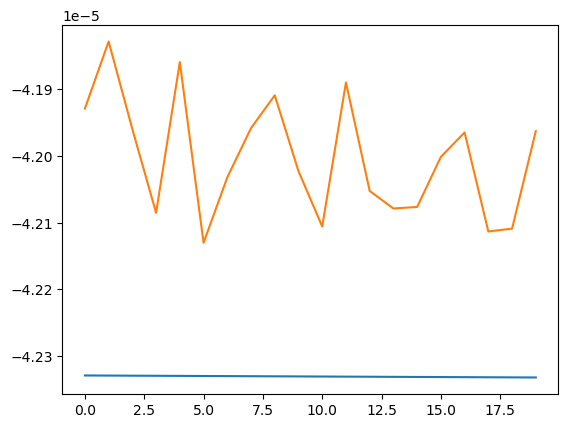

In [44]:
plt.plot(test_target, label = "Actual Data")
plt.plot(test_predict, label = "LSTM Predictions")
plt.savefig("small_plot.png", dpi = 300)
plt.show();

This is good. If we feed the last 100 days of information, our model successfully predicts a steady decline in the price of Bitcoin over the next 50 days. For one last plot, let's put this in perspective of the scale of the data. 

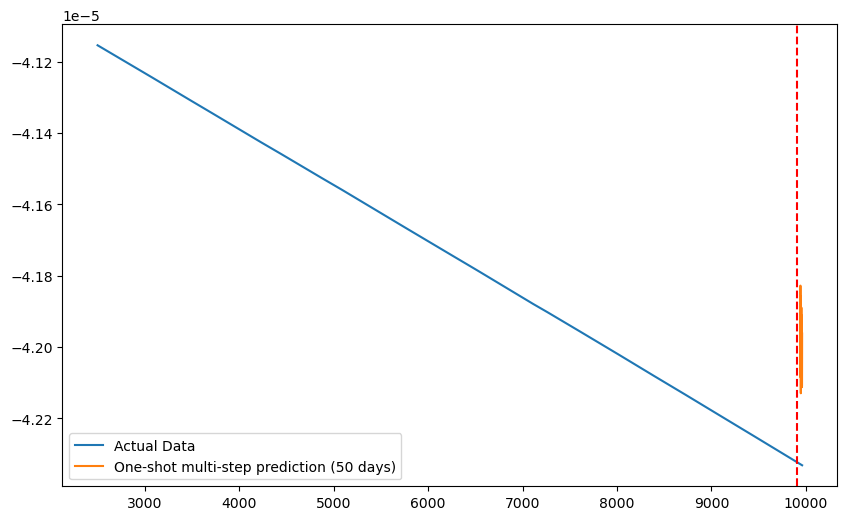

In [45]:
plt.figure(figsize=(10,6))
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label="Actual Data"); 
c = [x for x in range (len(y)-forward_window, len(y))]
plt.plot(c, test_predict, label = "One-shot multi-step prediction (50 days)")
plt.axvline(x=len(y)-50, c='r', linestyle="--")
plt.legend()
plt.show()

So, if we'd run our model on 26 Nov 2021, we would have been correct in selling off our Bitcoin. The model correctly predicts a price drop, as well as the rate at which it drops. 

This orange whole curve is generated without looking at ANY target data. Yes, to be fair, the model is very familiar with all the actual targets before the dashed red line. However, once we move past the training set into the test set the model has no idea what the test targets are. It has to generate its prediction  from the input feature only. 

# Conclusion

Interestingly, there's no info on the internet on how to construct multi-step out put LSTM models for multi-variate time-series data.

In [46]:
r2 = r2_score(test_target, test_predict)
r2

-137460.8600691317

In [47]:
test_target

[-4.2329178540967405e-05,
 -4.232933861203492e-05,
 -4.232949504512362e-05,
 -4.2329655116191134e-05,
 -4.232981154927984e-05,
 -4.232997162034735e-05,
 -4.233013169141486e-05,
 -4.233028812450357e-05,
 -4.233044819557108e-05,
 -4.2330604628659785e-05,
 -4.23307646997273e-05,
 -4.233092477079481e-05,
 -4.2331081203883514e-05,
 -4.2331241274951026e-05,
 -4.233139770803973e-05,
 -4.233155777910724e-05,
 -4.2331717850174755e-05,
 -4.233187428326346e-05,
 -4.233203435433097e-05,
 -4.233219078741968e-05]

In [48]:
test_predict

[-4.192883352516219e-05,
 -4.182817792752758e-05,
 -4.1959599911933765e-05,
 -4.2085252061951905e-05,
 -4.185906800557859e-05,
 -4.2130159272346646e-05,
 -4.2032064811792225e-05,
 -4.195818837615661e-05,
 -4.190894833300263e-05,
 -4.2022693378385156e-05,
 -4.210569750284776e-05,
 -4.1889663407346234e-05,
 -4.2052368371514603e-05,
 -4.207869278616272e-05,
 -4.207640085951425e-05,
 -4.2001280235126615e-05,
 -4.196459849481471e-05,
 -4.211316627333872e-05,
 -4.210893530398607e-05,
 -4.1962601244449615e-05]

In [49]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(test_target, test_predict)

3.3905795522169665e-07